In [1]:
import os
from io import BytesIO
import re
from urllib.parse import urlparse, urlunparse
import pandas as pd
import requests
import json
import time
from PIL import Image
from tqdm.auto import tqdm

In [2]:
proxies = {
    'http': 'http://localhost:7890',
    'https': 'http://localhost:7890'
    # 'http': 'http://10.68.98.153:7890',
    # 'https': 'http://10.68.98.153:7890'
}

headers = {'Content-Type': 'application/json'}

In [3]:
url = 'https://store.steampowered.com/api/appdetails/'

save_dir = '../dataset/scrap/steam/'

In [4]:
os.makedirs(os.path.join(save_dir, 'json'), exist_ok=True)
os.makedirs(os.path.join(save_dir, 'screenshot'), exist_ok=True)
os.makedirs(os.path.join(save_dir, 'header_image'), exist_ok=True)

In [5]:
js = json.load(open('../dataset/steam-games-dataset/games.json'))

In [6]:
def worker(appid):
    
    output_path = os.path.join(save_dir, 'json', f'{appid}.json')
    
    if os.path.exists(output_path):
        return True
    
    try:
        data = requests.get(f'{url}?appids={appid}', proxies=proxies)
        data = json.loads(data.content)
    except:
        return False
    
    json.dump(data, open(output_path, 'wt'))
    
    return True

In [7]:
file_names = list()
urls = list()
appids = list()

for appid, item in js.items():
    
    for url in item['screenshots']:
        file_names.append(os.path.split(urlparse(url).path)[-1])
        urls.append(url)
        appids.append(appid)

#     url = item['header_image']
    
#     file_names.append(os.path.split(urlparse(url).path)[-1])
#     urls.append(url)
#     appids.append(appid)

In [8]:
df = pd.DataFrame()

df['file_name'] = file_names
df['url'] = urls
df['appid'] = appids

df

,file_name,url,appid
0,0000005994.1920x1080.jpg,https://cdn.akamai.steamstatic.com/steam/apps/...,20200
1,0000005993.1920x1080.jpg,https://cdn.akamai.steamstatic.com/steam/apps/...,20200
2,0000005992.1920x1080.jpg,https://cdn.akamai.steamstatic.com/steam/apps/...,20200
3,0000006011.1920x1080.jpg,https://cdn.akamai.steamstatic.com/steam/apps/...,20200
4,0000005685.1920x1080.jpg,https://cdn.akamai.steamstatic.com/steam/apps/...,20200
...,...,...,...
622857,ss_95a3af03fa9d4325bd81c9274aa5fdef71f28aff.19...,https://cdn.akamai.steamstatic.com/steam/apps/...,2352890
622858,ss_e57da0f09a0cb30e7a572842d503741888837bf7.19...,https://cdn.akamai.steamstatic.com/steam/apps/...,2352890
622859,ss_78e7323b3bca5b179b5d27722ca3810384e5ed56.19...,https://cdn.akamai.steamstatic.com/steam/apps/...,2352890
622860,ss_fe177dba34a908a90dc911a9514594be12e7dde0.19...,https://cdn.akamai.steamstatic.com/steam/apps/...,2352890


In [9]:
def worker(url, output_path):
    
    if os.path.exists(output_path):
        return
    
    try:
        data = requests.get(url, proxies=proxies, timeout=(3.0, 10.0))
    except KeyboardInterrupt:
        return
    except:
        return

    if data.status_code != 200:
        return
    
    try:
        Image.open(BytesIO(data.content)).save(output_path)
    except:
        return
    
    return

In [10]:
for url, file_name in tqdm(df[['url', 'file_name']].itertuples(index=False, name=None), total=df.shape[0]):
    output_path = os.path.join(save_dir, 'screenshot', file_name)
    worker(url, output_path)
    # time.sleep(0.5)

  0%|          | 0/622862 [00:00<?, ?it/s]

# from torrent

In [22]:
import json

In [23]:
js = json.load(open('../dataset/steam-games-dataset/games.json'))

In [36]:
appids = set(map(int, js.keys()))

In [2]:
import bencodepy
import os
import zipfile

In [7]:
zf = zipfile.ZipFile('../dataset/scrap/steam/steam-games-scraped-2023-06-09-v1.torrent.zip')
f = zf.open('steam-games-scraped-2023-06-09-v1.torrent')

In [9]:
torrent_data = bencodepy.decode(f.read())

In [21]:
len(torrent_data[b'info'][b'files'])

95025

In [55]:
diff = [i for i in torrent_data[b'info'][b'files'] if (int(i[b'path'][0].split(b'.')[0]) not in appids) and (i[b'length'] > 1e3) and (i[b'length'] < 1e7)]

In [46]:
from matplotlib import pyplot

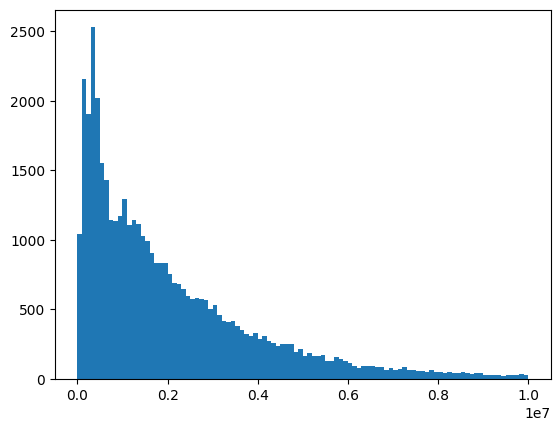

In [53]:
_ = pyplot.hist([i[b'length'] for i in diff], bins=100, range=(0, 1e7))

In [56]:
len(diff), sum([i[b'length'] for i in diff]) / 1e9

(42665, 88.042385148)

In [1]:
import libtorrent as lt
import time

In [2]:
ses = lt.session()
info = lt.torrent_info('steam-games-scraped-2023-06-09-v1.torrent')

In [3]:
settings = ses.get_settings()
settings['proxy_hostname'] = 'http://10.68.98.153'
settings['proxy_port'] = 7890

ses.apply_settings(settings)

In [4]:
save_path = './torrent_download/'

In [5]:
file_priorities = [1] * info.num_files()
# file_priorities[10] = 1

In [ ]:
h = ses.add_torrent({'ti': info, 'save_path': save_path, 'file_priorities': file_priorities})

print('downloading', h.name())

while not h.is_seed():
    s = h.status()
    print('%.2f%% complete (down: %.1f kB/s up: %.1f kB/s peers: %d) %s' % (
        s.progress * 100, s.download_rate / 1000, s.upload_rate / 1000,
        s.num_peers, s.state))

    time.sleep(100)

print('download complete')